## Importing Libraries

In [2]:
# Data Processing
import numpy as np
import pandas as pd
from collections import Counter

# Importing tde
import tde

# Visualization
import matplotlib.pyplot as plt

# Model and Performance
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report #for model performance evaluation

# To generate the for loops
import glob
import os
from matplotlib import ticker

## Reading the data

In [3]:
# Get the data
folder = "/Users/yoddmena/Downloads/Research/Telemetry_edited/"

files = glob.glob( folder + "Ex *.xlsx" ) 

minutes = []
temp = []

k = 0
for file in files:
    k = k +1
    if k > 2:
        break
    df = pd.read_excel(file) # reading the excel file
    
    file_min = df.iloc[:,0] #getting only the minutes
    file_temp = df.iloc[:,3::2] # slicing the data for only temperature
    
    minutes.append(file_min) # adding minutes into the list
    temp.append(file_temp) # adding the file into the list
  
     

## Scores for each dataset

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

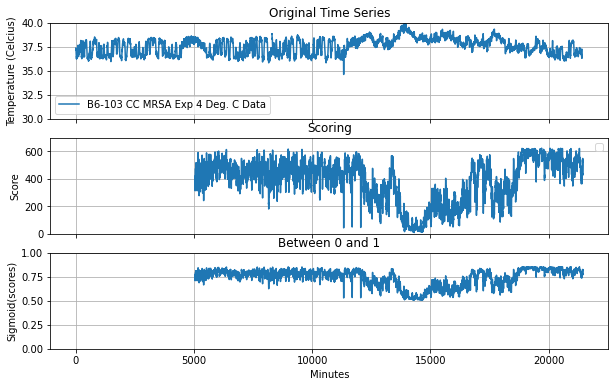

In [13]:
fig,ax = plt.subplots(3,1,figsize=(10,6), sharex = True)
fig.set_facecolor("white") # Changing the border to white

model = svm.OneClassSVM() # importing the model

# Sigmoid Definition
beta = (2/700)
def sigmoid(scores, beta):
    return 1 / (1 + np.exp(-beta * scores))

# Plotting each file's temperature vs. minutes
for i in range(len(minutes)):
    mouse_min = minutes[i] # renaming the minutes to the current column
    mouse_temp = temp[i] # renaming the temperature to the current column
    x_axis = mouse_min # defining the x axis
    
    # A for loop for the temperatures (extracting only the column of data frame)
    for j in range(mouse_temp.shape[1]): 
        ax[0].clear() # clear axis for each individual mouse
        ax[1].clear() # clear axis
        ax[2].clear()
        y_axis = mouse_temp.iloc[:,j] # defining the y axis
        names = mouse_temp.columns[j] # extracting the names of the columns (mouse name)
        
        # Filling in missing values using forward fill
        y1_fw = y_axis.fillna(method='ffill')
        y1_bw = y1_fw.fillna(method='bfill') #backward fill
        
        # Extracting column names
        #names = mouse_temp.columns[j] #doubled
        
        # Time Delay Embedding
        Y = tde.tde(y1_bw) #using the tde file
        Y = Y.T #transporting the data
        
        # Fit the Data
        model.fit(Y[:4321,:]) #training the data for the first 3 days (3*24*60)
                                ###starts on 720 b/c of the tde
                                ###need to change the ending value for Y
        # Predict the Data
        predict = model.predict(Y[4321:,:]) #predicting on the rest of the days
        scores = model.score_samples(Y[4321:,:]) #scoring on the rest of the days 
        
        # Plotting the Scatterplot
        ax[0].plot(x_axis, y_axis, label=names)
        ax[0].grid()
        ax[0].set_title("Original Time Series") # setting a title
        ax[0].set_ylabel("Temperature (Celcius)") # y label
        ax[0].legend() # name of the mouse
        ax[0].set_ylim(30,40) # y limits
        

        # Plotting the Scores
        ax[1].plot(x_axis[5041:],scores)
        ax[1].grid()
        ax[1].set_title("Scoring") # setting a title
        #ax[1].set_xlabel("Minutes") # x label
        ax[1].set_ylabel("Score") # y label
        ax[1].legend() # name of the mouse
        #ax[1].set_xlim(-5,) # x limits
        ax[1].set_ylim(0,700) # y limits
        
        # Values between 0 and 1 using sigmoid
        y = sigmoid(beta, scores)
        ax[2].plot(x_axis[5041:], y)
        ax[2].grid()
        ax[2].set_xlabel('Minutes')
        ax[2].set_ylabel('Sigmoid(scores)')
        ax[2].set_title('Between 0 and 1')
        ax[2].set_ylim(0,1)
        
        #fig.tight_layout()
        #fig.show()
        
        #SAVING EACH PLOT
        filename = "Scores/%s.png"%names # saving the file as the name of the mouse
        fig.savefig(filename)
        #print("Prediction for " + names, "is: \n", predict, "\n with score \n ", +  scores)